# Mobile Robotics: Project

The aim of our project is to detect two seperate Thymios, and switch their positions.

Our system is divided into the four following parts:
- **VISION**: We implement a robust vision framework to detect objects and more than one robots without error
- **GLOBAL NAVIGATION**: We use an A* algorithm to find the shortest and most efficient path between the two Thymios. This path is different for both robots to avoid collision
- **LOCAL NAVIGATION**: We use the proximity sensors to detect local obstacles. We avoid them while considering the global grid to avoid map obstacles as well. Once cleared, we recalculate the path with A*
- **FILTERING**: We implement a Kalman filter using the camera detections and the motors odometry to accurately monitor our position. When position is deviated over a threshold we try to compensate the error, or in extreme cases we recalculate the path with A*

**GROUP MEMBERS**

Thomas Kimble: 261204

Raphael Ausilio: 271504

Valentin Karam: 261200

Niccolo Stefanini: 269939

## 0. Imports and Connection

In [4]:
import cv2
import time
import numpy as np
import math
import os
import sys
import serial
import serial.tools.list_ports

from scipy.interpolate import interp1d

%matplotlib notebook 
import matplotlib.pyplot as plt
import matplotlib.image as img
from matplotlib import colors
%matplotlib notebook

# Adding the src folder in the current directory as it contains the script
# with the Thymio class and other main functionalities
sys.path.insert(0, os.path.join(os.getcwd(), 'src'))

import Filtering
import Vision
import GlobalNavigation

from Thymio import Thymio

Helper function to find Thymio ports 

In [2]:
comlist = serial.tools.list_ports.comports()
for port in comlist:
    if ("usbmodem" in str(port)):
        print(port.device)

/dev/cu.usbmodem142301
/dev/cu.usbmodem142401


In [3]:
thG = Thymio.serial(port="/dev/cu.usbmodem142301", refreshing_rate=0.1)
thR = Thymio.serial(port="/dev/cu.usbmodem142401", refreshing_rate=0.1)

In [4]:
thR.set_var_array("leds.top", [255, 0, 0])
thG.set_var_array("leds.top", [0, 255, 0])

## 1. Vision
We use an external webcam to take a birds eye image of our global map containing the global obstacles and the two Thymios. Multiple image processing techniques are used and will be described for each step. This part of the project is used to do the following:
- Take a picture of the global map
- Filter the image to get a binary remove impurities and noise
- Differentiate the two robots and get their position and orientation in the global map
- Differentiate robots and obstacles for global planning
- Creating an obstacle grid of a smaller size for said global planning

### 1.1 Global Map
We take a picture of the global map from above and import it as well as a black and white version. The black and white version will be used detecting shapes on the image (Thymios, obstacles or noise) and the colored image is used to detect and differentiate the green and red Thymios. We use a double circular shape on the Thymio to properly detect its center (bigger circle), and its orientation.

<IPython.core.display.Javascript object>


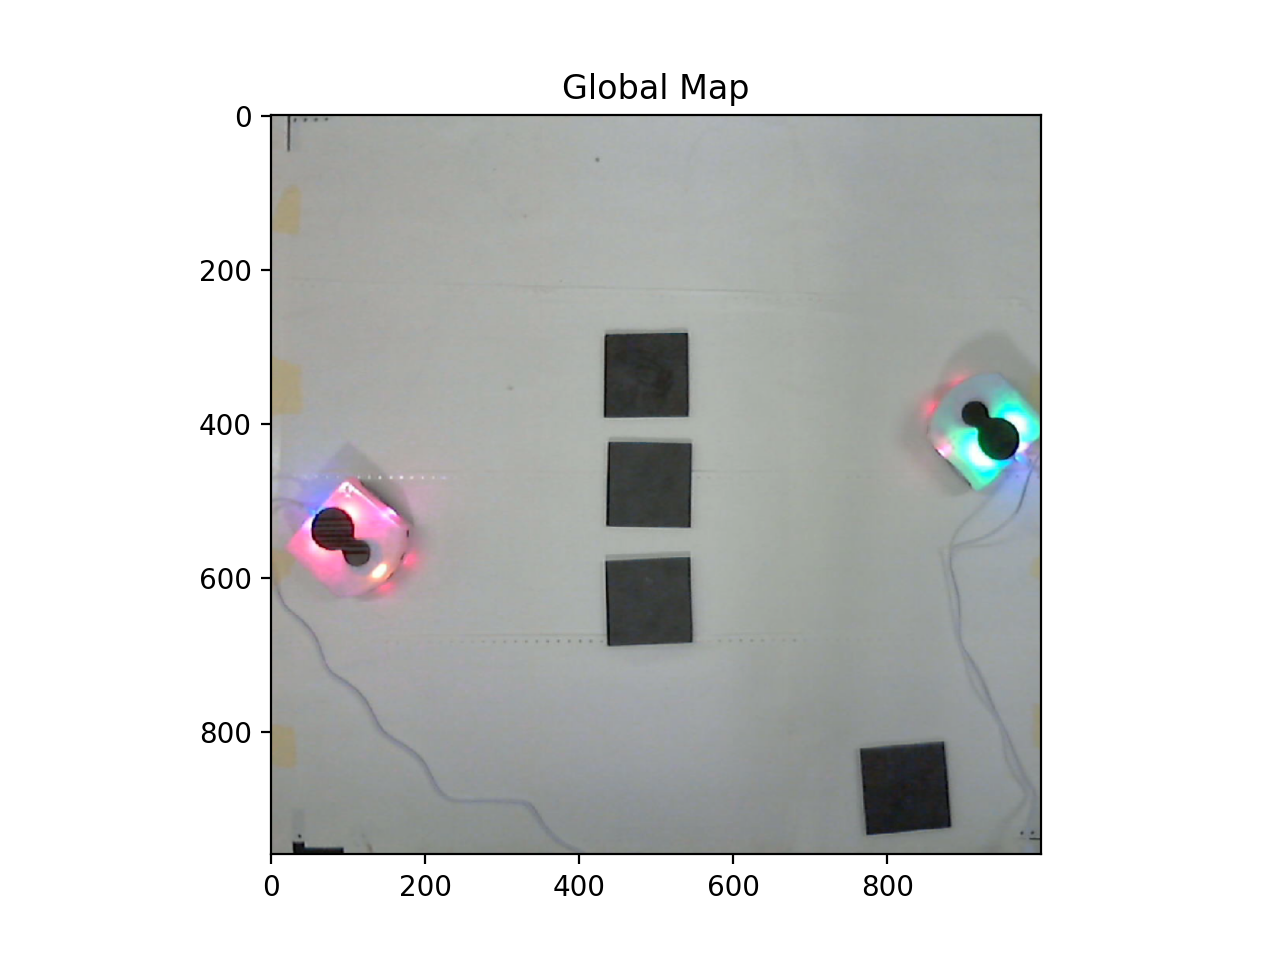

Text(0.5, 1.0, 'Global Map')

In [6]:
# Get color and grayscale images
webcamNumber = 1

# mapImg, mapBw, eq = Vision.loadImages(Vision.takePicture(webcamNumber))

mapImg, mapBw, eq = Vision.loadImages(1)

# Plot color image
plt.figure()
plt.imshow(mapImg)
plt.title("Global Map")

### 1.2 Filtering Global Map
We want to eliminate noise and get a clean image with mainly the Thymios and the obstacles. Two steps are involved here:
- Pre-processing the image through filtering and thresholding to get a binary image (two colors)
- Applying a morphological operator (opening) to the image to remove unwanted noise

Filtering the image with a bilateral filter assures a smooth background so no map features appear in in the filtered image. A binary image is wanted for proper shape detection without having to process color.

<IPython.core.display.Javascript object>


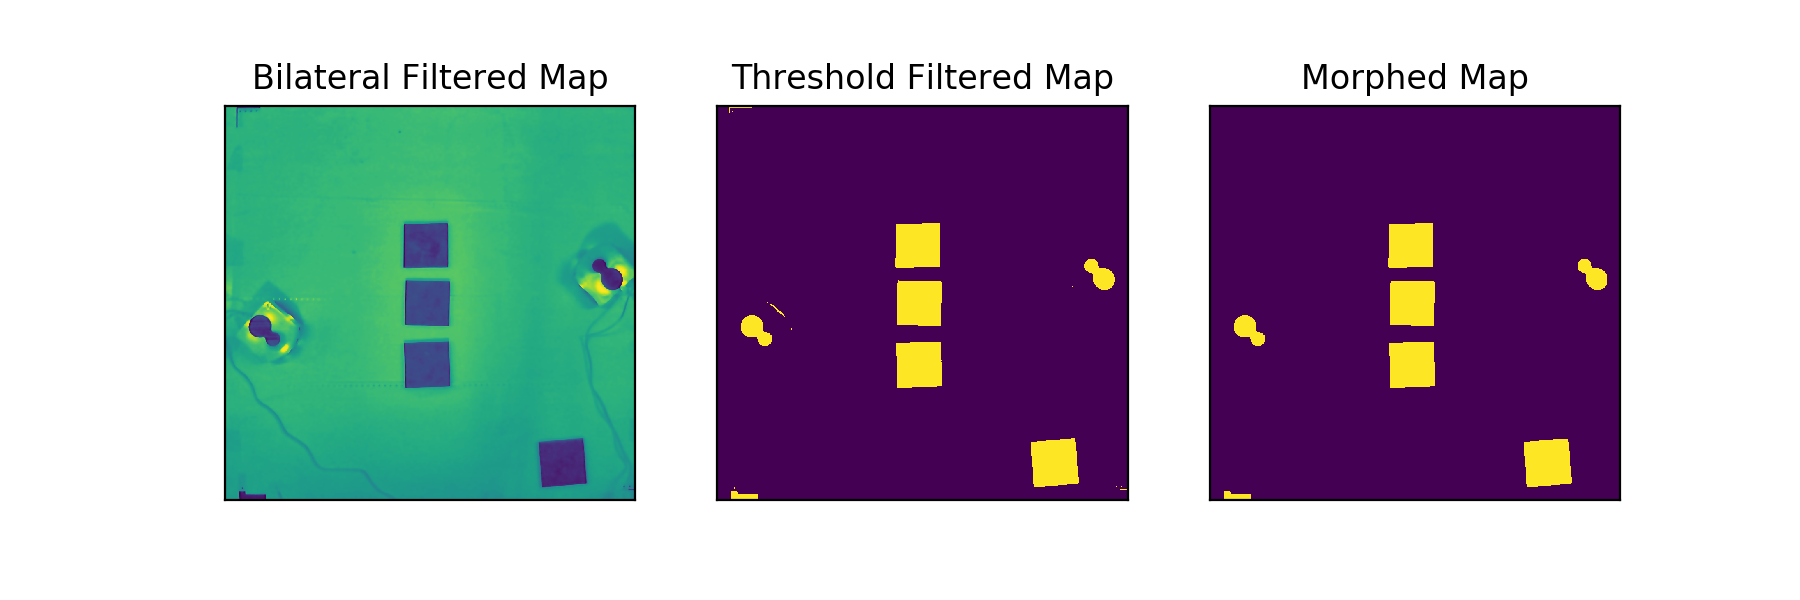

In [6]:
bilateral, thresh, opened = Vision.globalFilter(eq)

# Plot Images
titles = ['Bilateral Filtered Map', 'Threshold Filtered Map', 'Morphed Map']
images = [bilateral, thresh, opened]

plt.figure(figsize=(9,3))
for i in range(len(images)):
    plt.subplot(1,3,i+1),plt.imshow(images[i])
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

### 1.3 Filtering out Obstacles
We want to remove the obstacles to analyse the Thymios position and orientation. The big circle corresponds to the center of the thymio and the little circle is used to determine its orientation. For this, we compute the following morphological operators:
- Tophat and small erosion to remove the obstacles
- Opening and eroding to remove all but large circles
- Tophat, opening and eroding to remove all but small circles
- Adding both images together to get the four circles

Note that some impurities could be left because of cables or the edge of the map, but the blob detection will recognize these and not select them as circles.

<IPython.core.display.Javascript object>


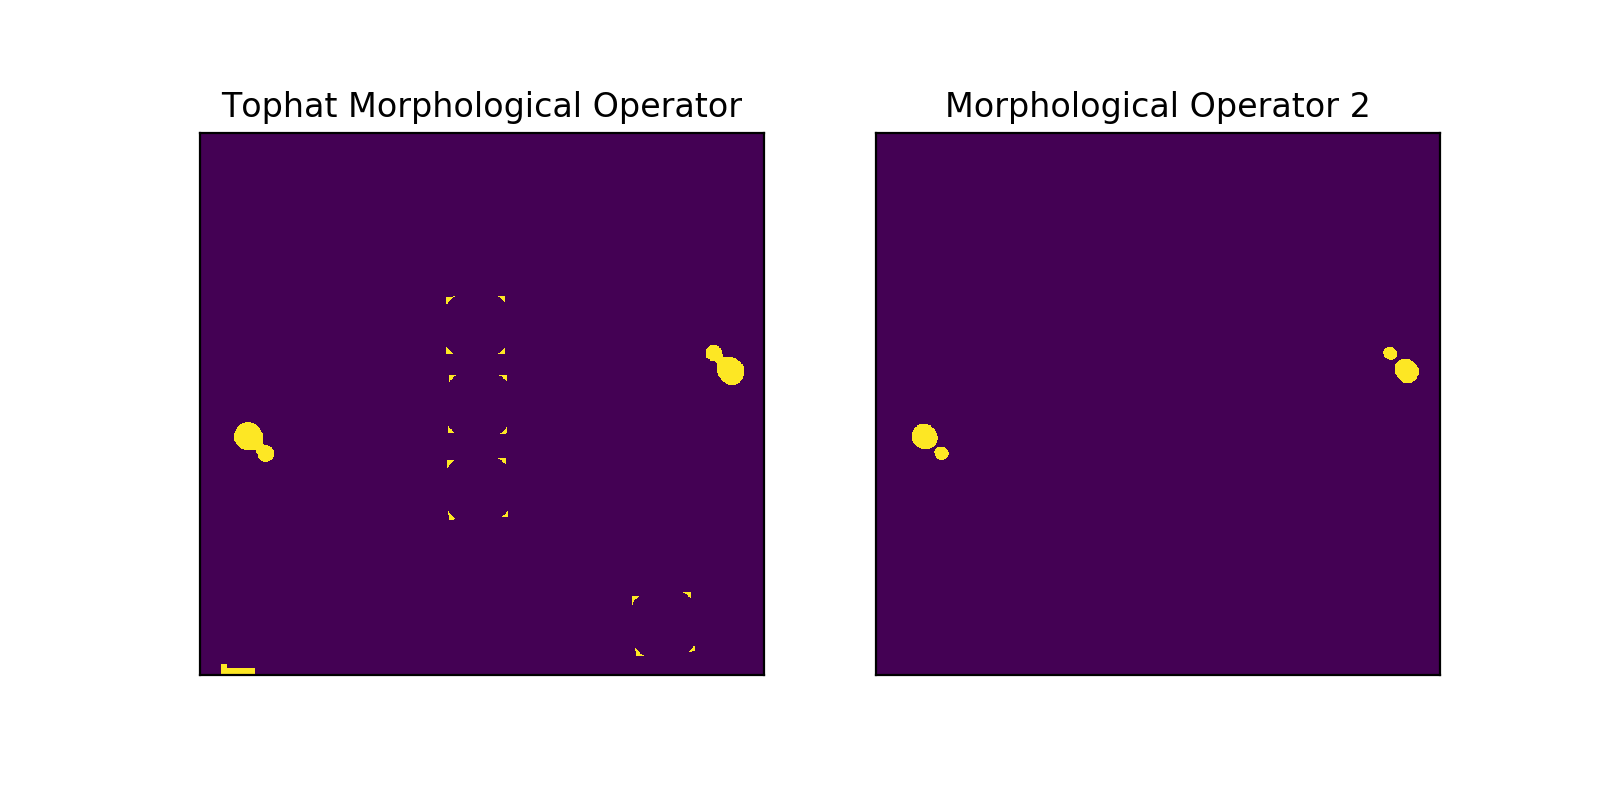

In [7]:
tophat, circles = Vision.obstacleFilter(opened)

# Plot Images
titles = ['Tophat Morphological Operator', 'Morphological Operator 2']
images = [tophat, circles]

plt.figure(figsize=(8,4))
for i in range(len(images)):
    plt.subplot(1,2,i+1),plt.imshow(images[i])
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

### 1.4 Thymio Detection
Here we acquire the size and position of the circles by using simple blob detection. From this information we can calculate the position and orientation for each Thymio. 

We then filter out all of the red in the image to only be left with green. After morphological operators on the green area, we can accurately compare its position to the blobs. From this we assign the green color to the green Thymio, which leaves us with the second Thymio being the red one.

We have now used vision to detect the two Thymio's position (x, y, theta). Note that theta is the angle between the x_axis and the Thymios orientation between 0 and 360 degrees clockwise.

<IPython.core.display.Javascript object>


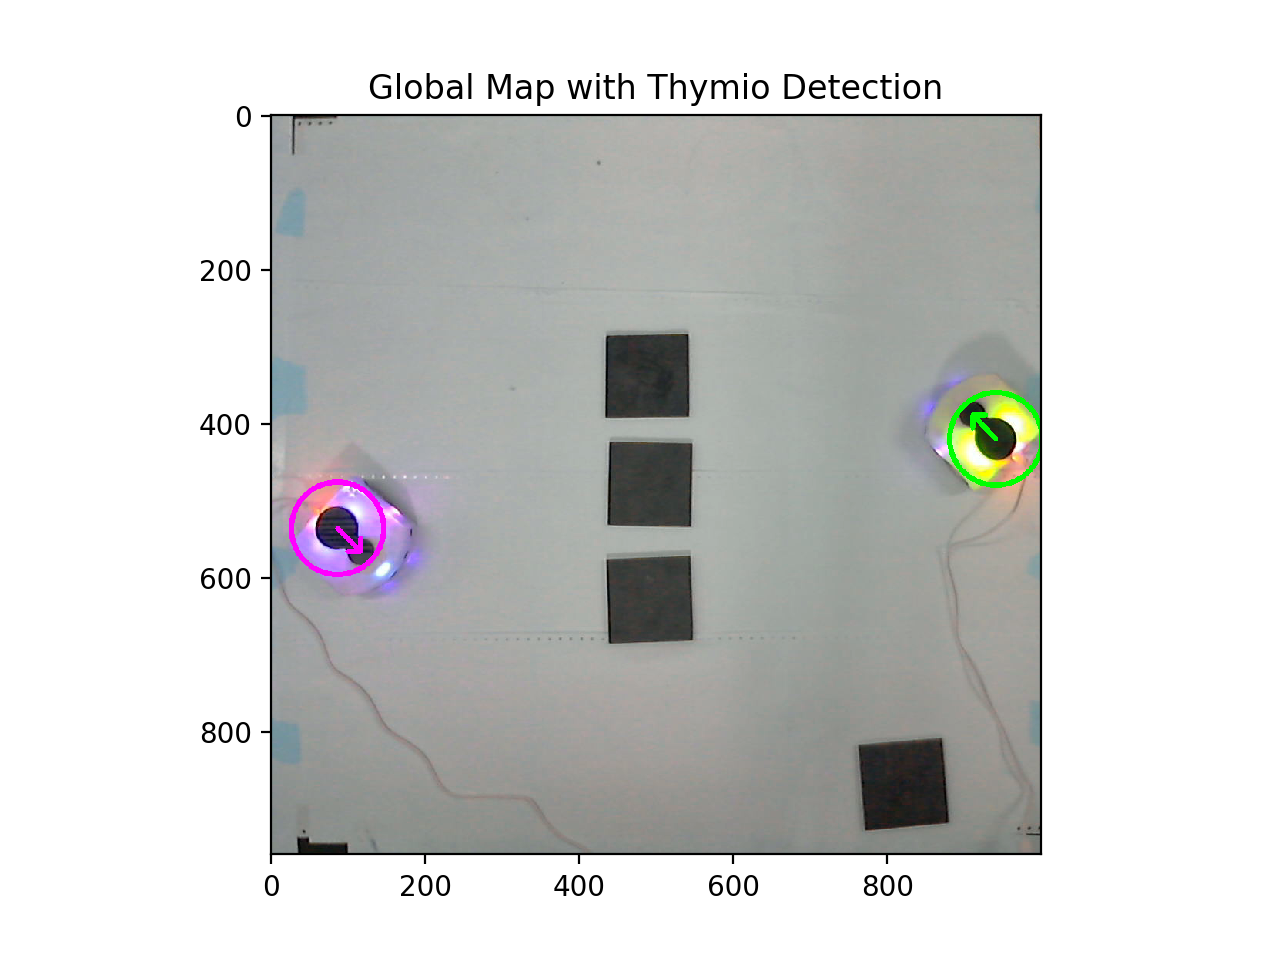

Green Thymio Position: [941. 421. 226.]
Red Thymio Position: [ 86. 537.  45.]


In [8]:
mapWithShapes, thymioGPos, thymioRPos, smallCircles = Vision.thymioDetection(circles, mapImg)

# Plot Image
plt.figure()
plt.imshow(mapWithShapes)
plt.title("Global Map with Thymio Detection")

# Print Thymio Details
print("Green Thymio Position:", thymioGPos)
print("Red Thymio Position:", thymioRPos)

### 1.5 Remove Thymios and Dilate Map
Here we remove the robots from the image. We first open the image with a kernel larger than the Thymio circles to be left with the obstacles. We then dilate the filtered image by a bit more than half of the size of the Thymio Robot to allow passage during global planning.

<IPython.core.display.Javascript object>


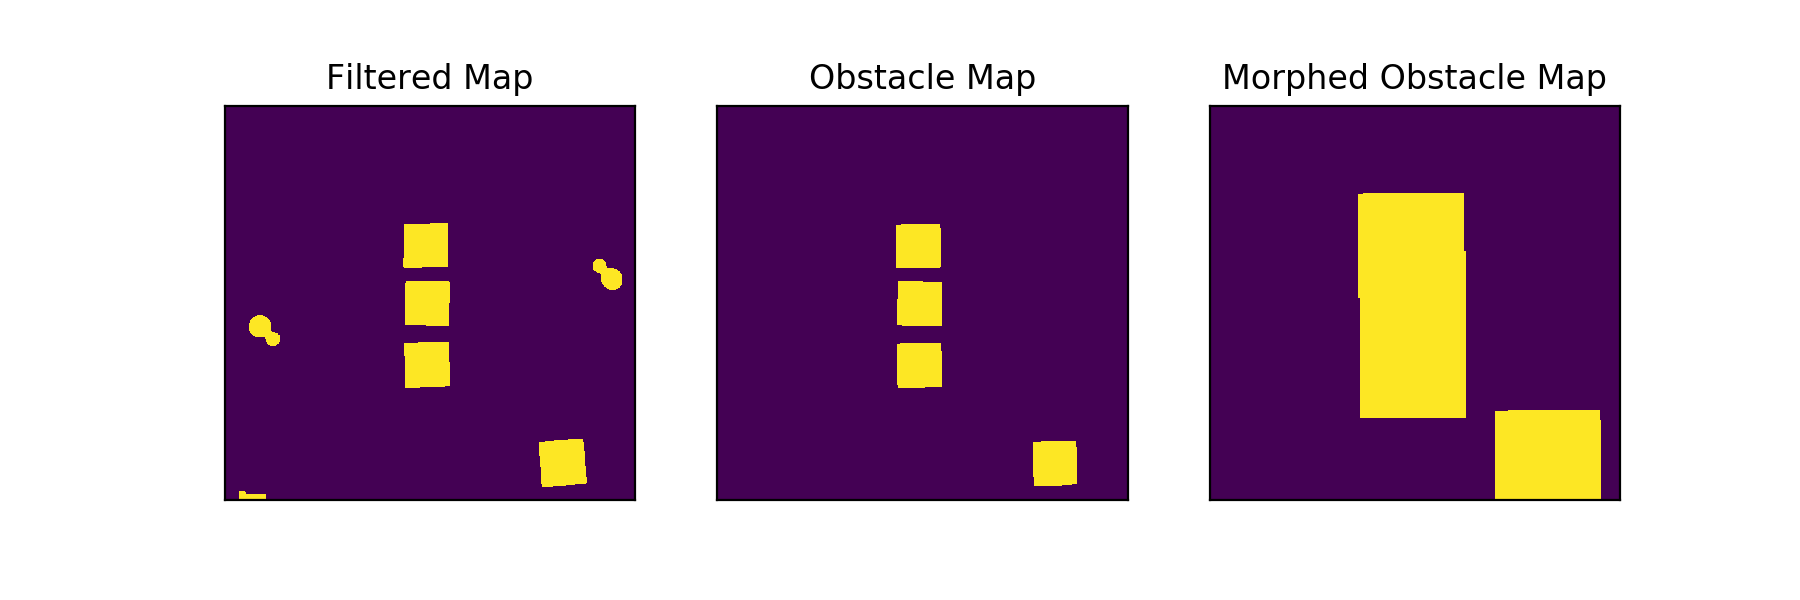

In [9]:
obstacles, morph = Vision.obstacleDetection(thresh)

# Plot Images
titles = ['Filtered Map', 'Obstacle Map', 'Morphed Obstacle Map']
images = [opened, obstacles, morph]

plt.figure(figsize=(9,3))
for i in range(len(images)):
    plt.subplot(1,3,i+1),plt.imshow(images[i])
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

### 1.6 Creating Grid
The images so far far are 1000 by 1000 pixels, but this is far too large to calculate global planning swiftly. We therefore reduce the size of the image by 20 to get a 50 by 50 grid.

For visualisation we plot this grid along with the morphed obstacles and the Thymios (showing orientation)

<IPython.core.display.Javascript object>


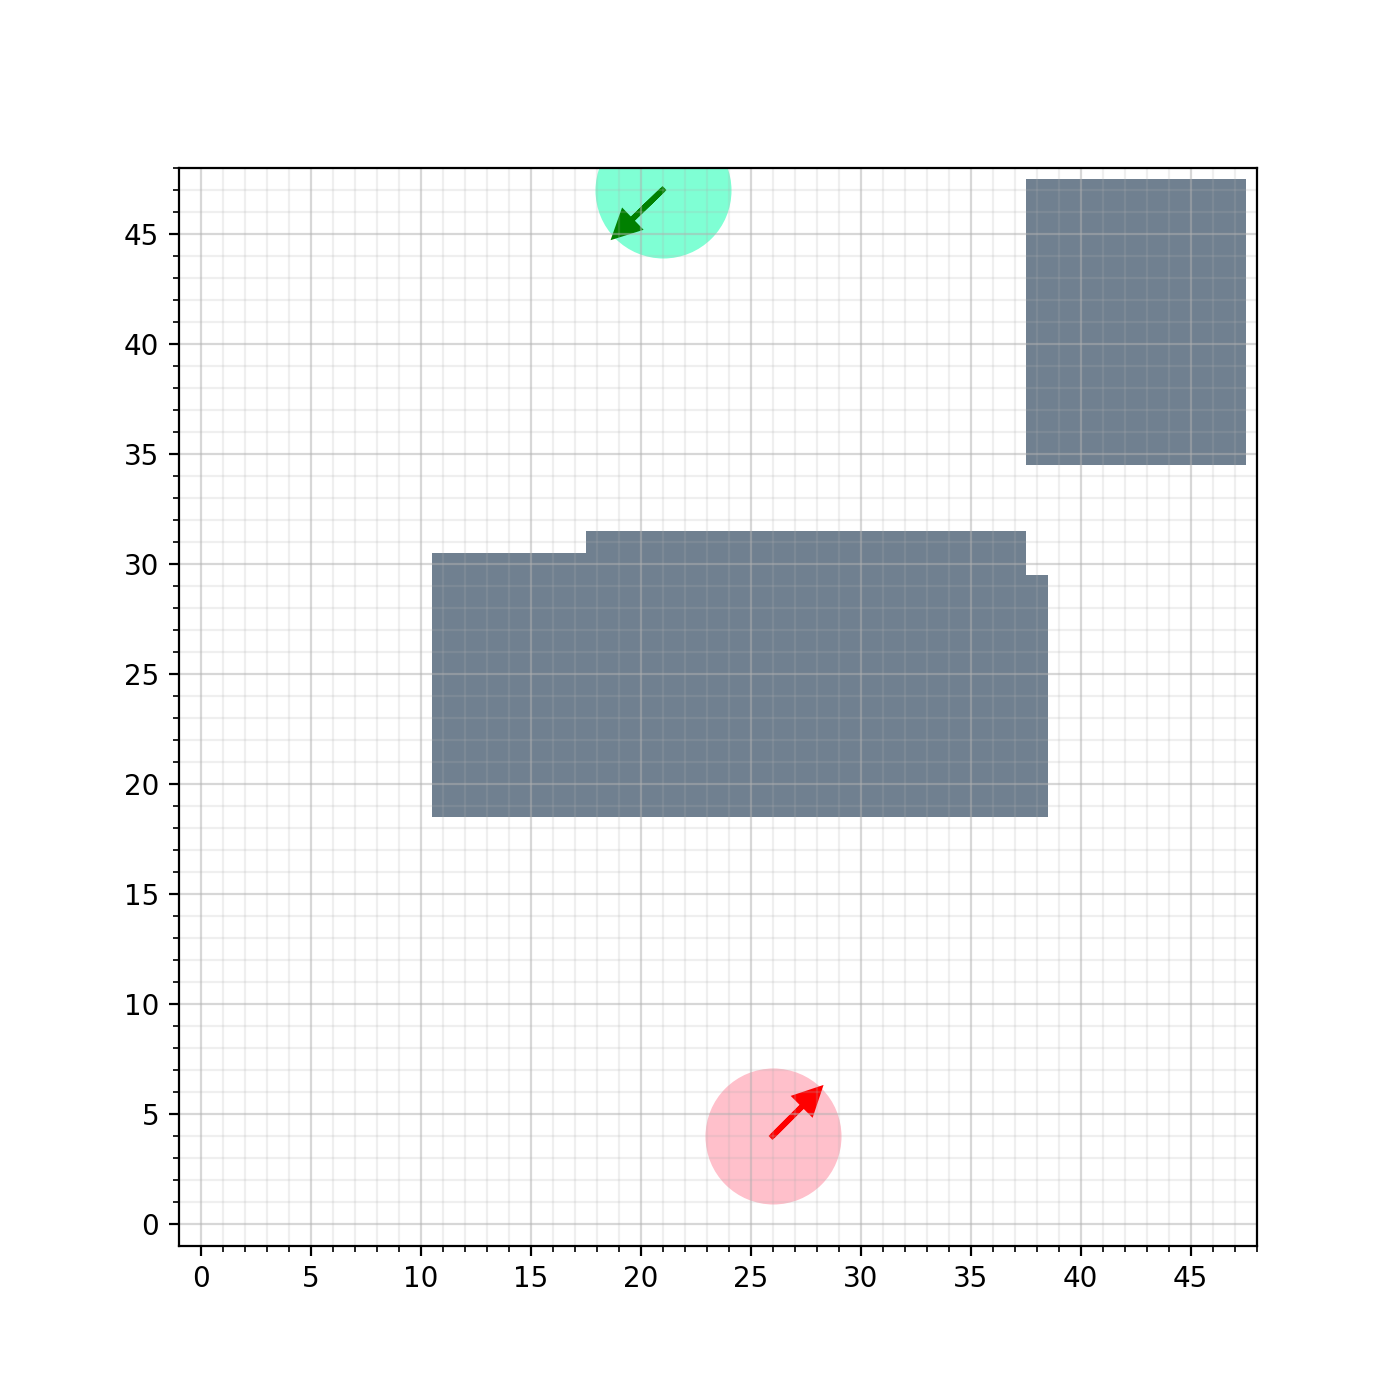

Green Thymio Position: (21, 47, 226)
Red Thymio Position: (26, 4, 45)


In [10]:
gridSize, ratio = Vision.getGridSize(mapBw)

# Fill morphed obstacle grid (occupancyGrid) and normal obstacle grid (obstacleGrid)
occupancyGrid, obstacleGrid, ax, cmap = Vision.fillGrid(gridSize, ratio, obstacles, morph, 1)

# Update Thymio position for new grid
thymioG = (int(thymioGPos[1]/ratio), int(thymioGPos[0]/ratio), int(thymioGPos[2]))
thymioR = (int(thymioRPos[1]/ratio), int(thymioRPos[0]/ratio), int(thymioRPos[2]))

# Print Thymio Details
print("Green Thymio Position:", thymioG)
print("Red Thymio Position:", thymioR)

# Displaying the map
ax.imshow(occupancyGrid.transpose(), cmap=cmap)
ax.scatter(thymioG[0], thymioG[1], marker="o", color = 'aquamarine', s=2300);
ax.arrow(thymioG[0], thymioG[1], 2*math.sin(thymioG[2]*np.pi/180),
         2*math.cos(thymioG[2]*np.pi/180), head_width=1, head_length=1, fc='g', ec='g', lw=2)
ax.scatter(thymioR[0], thymioR[1], marker="o", color = 'pink', s=2300);
ax.arrow(thymioR[0], thymioR[1], 2*math.sin(thymioR[2]*np.pi/180),
         2*math.cos(thymioR[2]*np.pi/180), head_width=1, head_length=1, fc='r', ec='r', lw=2)

# 2. Global Navigation

### 2.1 A* Algorithm
For the Green Thymio:
- We implement the A* algorithm to find the shortest path between the two robots.
- We use the morphed obstacle map to assure no obstacles will be hit during our global navigation.
- We use the first order norm to allow for faster calculations.
- We save the robots half-way position so it acts as an obstacle for the Red Thymio

For the Red Thymio:
- We implement the A* algorithm to find the shortest path between the two robots.
- We add a square with the width of a Thymio to act as an obstacle as explained above.
- We use the morphed obstacle map (with the Green Thymio at its half-way point)
- We use the first order norm to allow for faster calculations.

<IPython.core.display.Javascript object>


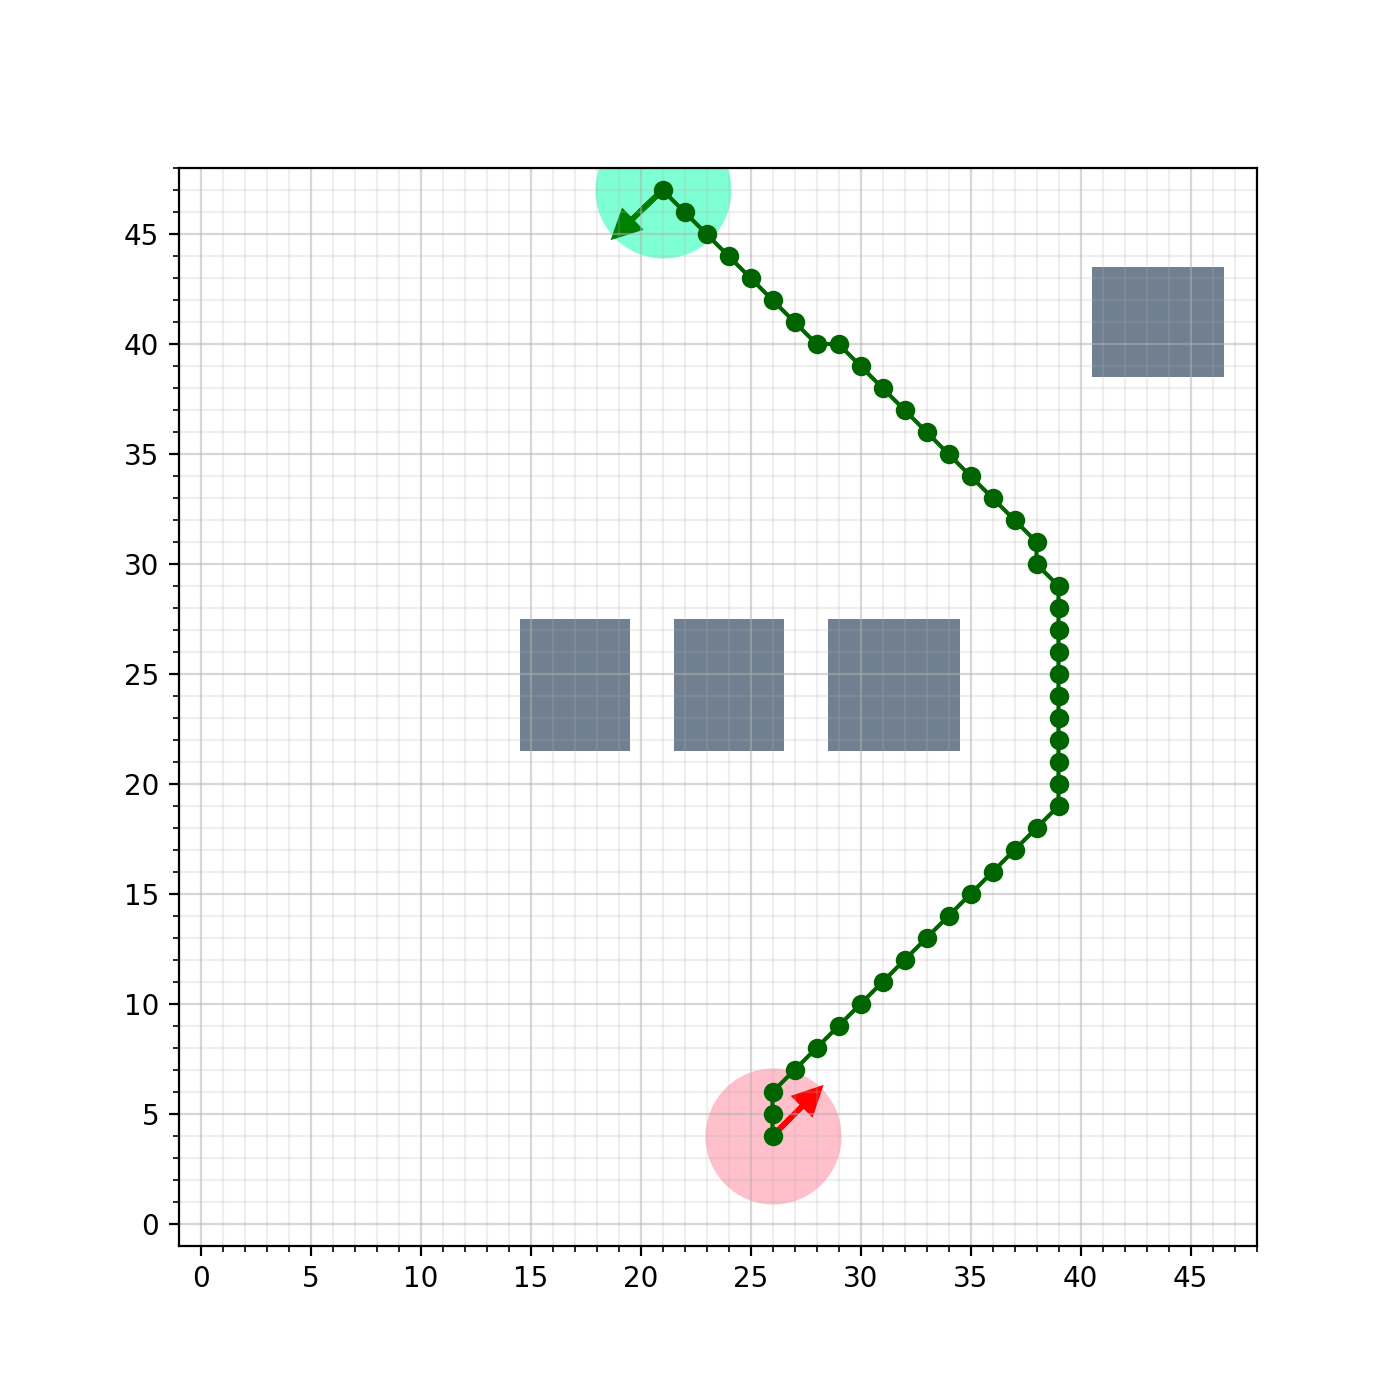

In [11]:
pathCoords, path, axAStar, cmap = GlobalNavigation.runAStarSingle(gridSize, obstacleGrid, occupancyGrid, (thymioG[0],thymioG[1]), (thymioR[0],thymioR[1]), 1)

# Displaying the map
axAStar.imshow(obstacleGrid.transpose(), cmap=cmap)

# Plot the best path found and the list of visited nodes
axAStar.plot(path[0], path[1], marker="o", color = 'darkgreen');
# Plot Start (Green Thymio)
axAStar.scatter(thymioG[0], thymioG[1], marker="o", color = 'aquamarine', s=2300);
axAStar.arrow(thymioG[0], thymioG[1], 2*math.sin(thymioG[2]*np.pi/180),
         2*math.cos(thymioG[2]*np.pi/180), head_width=1, head_length=1, fc='g', ec='g', lw=2)
# Plot End (Red Thymio)
axAStar.scatter(thymioR[0], thymioR[1], marker="o", color = 'pink', s=2300);
axAStar.arrow(thymioR[0], thymioR[1], 2*math.sin(thymioR[2]*np.pi/180),
         2*math.cos(thymioR[2]*np.pi/180), head_width=1, head_length=1, fc='r', ec='r', lw=2)

<IPython.core.display.Javascript object>


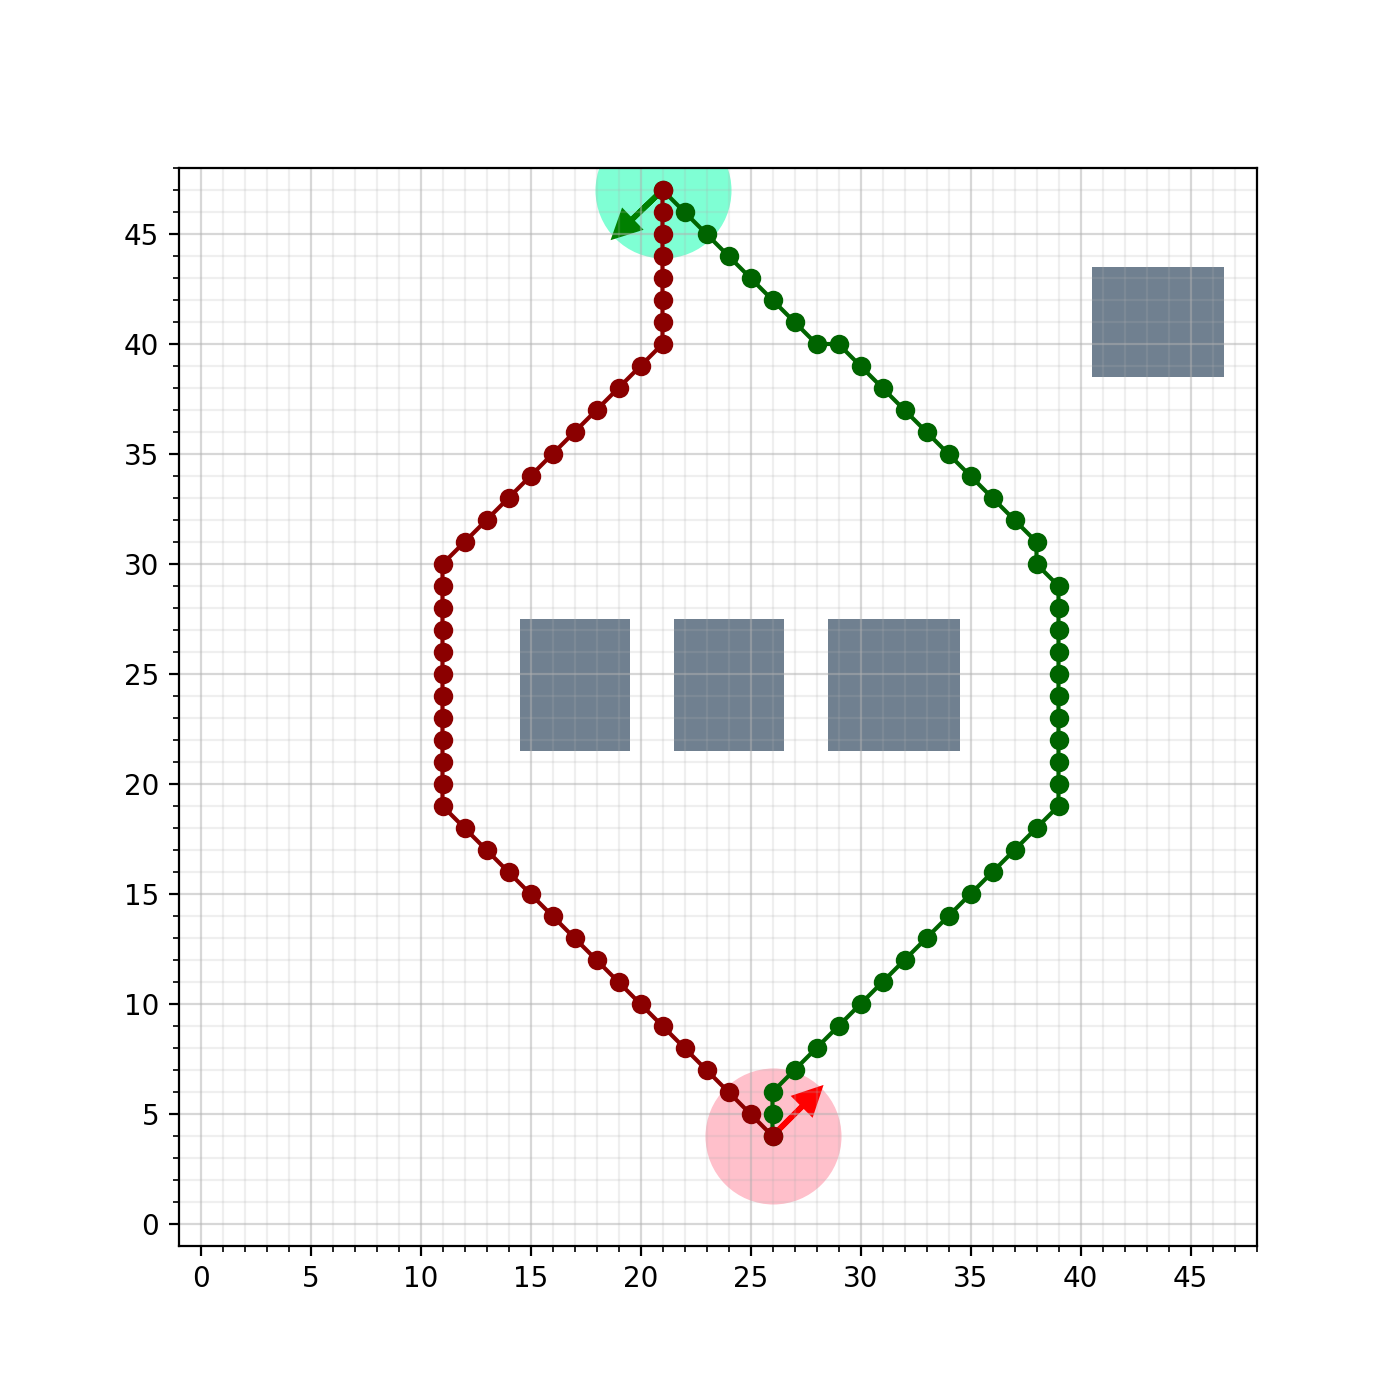

In [12]:
pathCoordsG, pathG, pathCoordsR, pathR, axAStar, cmap = GlobalNavigation.runAStarSwitch(gridSize, obstacleGrid, occupancyGrid, (thymioG[0],thymioG[1]), (thymioR[0],thymioR[1]), 1)

# Displaying the map
axAStar.imshow(obstacleGrid.transpose(), cmap=cmap)

# Plot the best path found and the list of visited nodes
axAStar.plot(pathG[0], pathG[1], marker="o", color = 'darkgreen');
axAStar.plot(pathR[0], pathR[1], marker="o", color = 'darkred');
# Plot Start (Green Thymio)
axAStar.scatter(thymioG[0], thymioG[1], marker="o", color = 'aquamarine', s=2300);
axAStar.arrow(thymioG[0], thymioG[1], 2*math.sin(thymioG[2]*np.pi/180),
         2*math.cos(thymioG[2]*np.pi/180), head_width=1, head_length=1, fc='g', ec='g', lw=2)
# Plot End (Red Thymio)
axAStar.scatter(thymioR[0], thymioR[1], marker="o", color = 'pink', s=2300);
axAStar.arrow(thymioR[0], thymioR[1], 2*math.sin(thymioR[2]*np.pi/180),
         2*math.cos(thymioR[2]*np.pi/180), head_width=1, head_length=1, fc='r', ec='r', lw=2)

### 2.2 Parameter Functions
Here we create the different parameters we are going to use for navigation:
- **posArray**: an array of the global path positions [ [x y orientation] ... [x y orientation] ]
- **movArray**: an array of the movements for the global path [ [dx dy] ... [dx dy] ]
- **dirArray**: an array of the directions (relative to the robots current position) for the global path [d d ... d]

The orientation and directions are defined as follows:

<img src="images/Navigation.png"
     alt="Markdown Monster icon"
     style="float: left; margin-right: 10px;" />

We also create a function to update the robots coordinates after each movement (this will also be used for local navigation).

(NOTE: please find these functions in 'GlobalNavigation.py')

### 2.3 Navigation Functions
These functions are for the motor control to navigate the robot.

(NOTE: please find these functions in 'GlobalNavigation.py')

In [13]:
posArrayG, movementArrayG, directionArrayG = GlobalNavigation.getParameters(thG, thymioG[2], pathCoordsG)
currentPosG = np.array(posArrayG[0])
previousPosG = np.empty(0)

posArrayR, movementArrayR, directionArrayR = GlobalNavigation.getParameters(thR, thymioR[2], pathCoordsR)
currentPosR = np.array(posArrayR[0])
previousPosR = np.empty(0)

91.0 degree left turn
90.0 degree left turn


## 3. Local Navigation

### 3.1 Obstacle avoidance

The thymio uses the strength of the prox captors to avoid local obstacles.

The thymio updates its position and direction, and uses them to check the presence of global obstacles, using the same state machine as for local obstacle.

When the thyimo has passed around the obstacle, it calls A* Algorithm to recalculate path.

In [14]:
def directionToMovement(o, d):
    mov = np.zeros(2)
    
    if (o == 0 and d == STRAIGHT) or (o == 1 and d == LEFT) or (o == 7 and d == RIGHT):
        mov[0] = 0
        mov[1] = 1
    elif (o == 1 and d == STRAIGHT) or (o == 2 and d == LEFT) or (o == 0 and d == RIGHT):
        mov[0] = 1
        mov[1] = 1
    elif (o == 2 and d == STRAIGHT) or (o == 3 and d == LEFT) or (o == 1 and d == RIGHT):
        mov[0] = 1
        mov[1] = 0
    elif (o == 3 and d == STRAIGHT) or (o == 4 and d == LEFT) or (o == 2 and d == RIGHT):
        mov[0] = 1
        mov[1] = -1
    elif (o == 4 and d == STRAIGHT) or (o == 5 and d == LEFT) or (o == 3 and d == RIGHT):
        mov[0] = 0
        mov[1] = -1
    elif (o == 5 and d == STRAIGHT) or (o == 6 and d == LEFT) or (o == 4 and d == RIGHT):
        mov[0] = -1
        mov[1] = -1
    elif (o == 6 and d == STRAIGHT) or (o == 7 and d == LEFT) or (o == 5 and d == RIGHT):
        mov[0] = -1
        mov[1] = 0
    elif (o == 7 and d == STRAIGHT) or (o == 0 and d == LEFT) or (o == 6 and d == RIGHT):
        mov[0] = -1
        mov[1] = 1
    return mov

def resumePath(pos, prevPos, path):
    t = 0
    o = 0
    pathIndex = 0
    newPos = pos
    newPrevPos = prevPos
    
    # Check if position is in path
    for i in range(len(path)):
        if pos[0] == path[i][0] and pos[1] == path[i][1]:
            t = 1
            o = path[i][2]
            pathIndex = i
            
    # If so, turn to correct robot orientation
    if t == 1:
        n = int(abs(o-pos[2]))
        if (pos[0] < o):
            if n > 4:
                n = 8-n
                right = False
            else:
                right = True
        else:
            if n > 4:
                n = 8-n
                right = True
            else:
                right = False

        for i in range(n):
            if right:
                turnRight()
                m = directionToMovement(newPos[2], RIGHT)
                newPos, newPrevPos = updateCoords(newPos, newPrevPos, m, RIGHT)
            else:
                turnLeft()
                m = directionToMovement(newPos[2], LEFT)
                newPos, newPrevPos = updateCoords(newPos, newPrevPos, m, LEFT)
    
    return newPos, newPrevPos, pathIndex


def checkPath(pos, path):
    t = 0
    o = 0
    # Check if position is in path
    for i in range(len(path)):
        if pos[0] == path[i][0] and pos[1] == path[i][1]:
            t = 1
            o = path[i][2]
    # If so, turn to correct robot orientation
    if t == 1:
        print("GLOBAL PATH FOUND!!!")
        return True
    else:
        return False
    

def sensor_val_to_grid(val):
    """
    Returns the distance corresponding to the sensor value based 
    on the sensor characteristics
    :param val: sensor value
    :return: distance in cm
    """
    sensor_distances = np.array([i for i in range(0,21)])
    sensor_measurements = np.array([5120, 4996, 4964, 4935, 4554, 4018, 3624, 3292, 2987, 
              2800, 2580, 2307, 2039, 1575, 1127, 833, 512, 358, 157, 52, 0])
    if val == 0:
        return np.inf

    f = interp1d(sensor_measurements, sensor_distances)               #1 unit = 1.86cm
    return (f(val)/1.86).item()



def checkGlobalRight(obstacleGrid, newPos):
    detection_level1 = "nothing ahead"

    sensorCone1 = [math.sin(((newPos[2]-1)%8)*math.pi/4)*2 + newPos[0] , math.cos(((newPos[2]-1)%8)*math.pi/4)*2+newPos[1]]    

    if obstacleGrid[math.floor(sensorCone1[0]),math.floor(sensorCone1[1])] == 1 :
        detection_level1 = "detected close"
    else:
        sensorCone1 = [math.sin(((newPos[2]-1)%8)*45)*3 + newPos[0] , math.cos(((newPos[2]-1)%8)*45)*3+newPos[1]]
        if obstacleGrid[math.floor(sensorCone1[0]),math.floor(sensorCone1[1])] == 1:
            detection_level1 = "detect but far" 
    
    return detection_level1
    
def checkGlobalLeft(obstacleGrid, newPos):
    detection_level2 = "nothing ahead"
    
    sensorCone2 = [math.sin(((newPos[2]+1)%8)*45)*2 + newPos[0] , math.cos(((newPos[2]+1)%8)*45)*2+newPos[1]]
    if obstacleGrid[math.floor(sensorCone2[0]),math.floor(sensorCone2[1])] == 1 :
        detection_level2 = "detected close"
    else:
        sensorCone2 = [math.sin(((newPos[2]+1)%8)*45)*3 + newPos[0] , math.cos(((newPos[2]+1)%8)*45)*3+newPos[1]]
        if obstacleGrid[math.floor(sensorCone2[0]),math.floor(sensorCone2[1])] == 1:
            detection_level2 = "detect but far"

    return detection_level2
    

def checkGlobalCenter(obstacleGrid, newPos):
    detection_level0 = "nothing ahead"
   
    sensorCone0 = [math.sin(newPos[2]*45)*2 + newPos[0] , math.cos(newPos[2]*45)*2+newPos[1]]
    if obstacleGrid[math.floor(sensorCone0[0]),math.floor(sensorCone0[1])] == 1 :
        detection_level0 = "detected close"
    else:
        sensorCone0 = [math.sin(newPos[2]*45)*3 + newPos[0] , math.cos(newPos[2]*45)*3+newPos[1]]
        if obstacleGrid[math.floor(sensorCone0[0]),math.floor(sensorCone0[1])] == 1:
            detection_level0 = "detect but far"
            
    return detection_level0

def checkLocalLeft(thG) : 
    detection_level = "nothing ahead"
    sensor4 = sensor_val_to_grid(thG["prox.horizontal"][4])
    sensor3 = sensor_val_to_grid(thG["prox.horizontal"][3])
    sensor2 = sensor_val_to_grid(thG["prox.horizontal"][2])
    if ((sensor4 <= 2) or (sensor3 <= 2) or (sensor2 <= 2)):
        detection_level = "detected close"
    elif (4 > sensor4 > 2) and (sensor3 > 3) :
        detection_level = "detect but far"                  #during following
    elif (sensor4 == 0) and (sensor3 == 0):
        detection_level = "nothing ahead"
    return detection_level

def contourLeft(pos, prevPos, path,thG):
    m = directionToMovement(pos[2], LEFT)
    GlobalNavigation.turnRight(thG)
    GlobalNavigation.goForwards(thG, 1)
    pos, prevPos = GlobalNavigation.updateCoords(pos, prevPos, m, LEFT)
    if not checkPath(pos, path): 
        while True:
            if checkLocalLeft(thG) == "detected close" or checkGlobalLeft(obstacleGrid, pos) == "detected close" or checkGlobalCenter(obstacleGrid, pos) == "detected close" :
                GlobalNavigation.turnLeft(thG)
                GlobalNavigation.goForwards(thG,1)
                m = directionToMovement(pos[2], LEFT)
                pos, prevPos = GlobalNavigation.updateCoords(pos, prevPos, m, LEFT)

            elif checkLocalLeft(thG) == "detect but far"  or checkGlobalLeft(obstacleGrid, pos) == "detect but far": #get closer
                GlobalNavigation.goForwards(thG, 2)
                m = directionToMovement(pos[2], 0)
                pos, prevPos = GlobalNavigation.updateCoords(pos, prevPos, m, STRAIGHT)

            elif checkLocalLeft(thG) == "nothing ahead" or checkGlobalLeft(obstacleGrid, pos) == "nothing ahead" :
                GlobalNavigation.goForwards(thG, 1)
                m = directionToMovement(pos[2], STRAIGHT)
                pos, prevPos = GlobalNavigation.updateCoords(pos, prevPos, m, STRAIGHT)

                GlobalNavigation.goForwards(thG, 1)
                m = directionToMovement(pos[2], STRAIGHT)
                pos, prevPos = GlobalNavigation.updateCoords(pos, prevPos, m, STRAIGHT)

                GlobalNavigation.turnLeft(thG)
                GlobalNavigation.goForwards(thG, 1)
                m = directionToMovement(pos[2], RIGHT)
                pos, prevPos = GlobalNavigation.updateCoords(pos, prevPos, m, RIGHT)
                
                if checkLocalLeft(thG) == "nothing ahead" or checkGlobalLeft(obstacleGrid, pos) == "nothing ahead" :
                    GlobalNavigation.stop(thG)                    
                    break 
                
                
            GlobalNavigation.stop(thG)
            time.sleep(0.01)
            
        pos, prevPos, pathIndex = resumePath(pos, prevPos, path)
    return pos, prevPos, pathIndex


def checkLocalRight(thG):
    detection_level= "nothing ahead"
    sensor2 = sensor_val_to_grid(thG["prox.horizontal"][2])
    sensor1 = sensor_val_to_grid(thG["prox.horizontal"][1])
    sensor0 = sensor_val_to_grid(thG["prox.horizontal"][0])
    
    if ((sensor0 <= 2) or (sensor1 <= 2) or (sensor2 <= 2)):
        detection_level = "detected close"
    elif (4 > sensor0 > 2) and (sensor1 > 3) :
        detection_level = "detect but far"                  #during following
    elif (sensor0 == 0) and (sensor1 == 0):
         detection_level = "nothing ahead"
  
    return detection_level

def contourRight(pos, prevPos, path, thG):
    m = directionToMovement(pos[2], RIGHT)
    GlobalNavigation.turnLeft(thG)
    GlobalNavigation.goForwards(thG, 1)
    pos, prevPos = GlobalNavigation.updateCoords(pos, prevPos, m, RIGHT)
    if not checkPath(pos, path): 
        while True:
            if checkLocalRight(thG) == "detected close" or checkGlobalRight(obstacleGrid, pos) == "detected close" or checkGlobalCenter(obstacleGrid, pos) == "detected close" :
                GlobalNavigation.turnRight(thG)
                GlobalNavigation.goForwards(thG,1)
                m = directionToMovement(pos[2], RIGHT)
                pos, prevPos = GlobalNavigation.updateCoords(pos, prevPos, m, RIGHT)

            elif checkLocalRight(thG) == "detect but far"  or checkGlobalRight(obstacleGrid, pos) == "detect but far": #get closer
                GlobalNavigation.goForwards(thG, 2)
                m = directionToMovement(pos[2], 0)
                pos, prevPos = GlobalNavigation.updateCoords(pos, prevPos, m, STRAIGHT)

            elif checkLocalLeft(thG) == "nothing ahead" or checkGlobalLeft(obstacleGrid, pos) == "nothing ahead" :
                GlobalNavigation.goForwards(thG, 1)
                m = directionToMovement(pos[2], STRAIGHT)
                pos, prevPos = GlobalNavigation.updateCoords(pos, prevPos, m, STRAIGHT)

                GlobalNavigation.goForwards(thG, 1)
                m = directionToMovement(pos[2], STRAIGHT)
                pos, prevPos = GlobalNavigation.updateCoords(pos, prevPos, m, STRAIGHT)
                
                GlobalNavigation.turnRight(thG)
                GlobalNavigation.goForwards(thG, 1)
                m = directionToMovement(pos[2], LEFT)
                pos, prevPos = GlobalNavigation.updateCoords(pos, prevPos, m, LEFT)
                if checkLocalLeft(thG) == "nothing ahead" or checkGlobalLeft(obstacleGrid, pos) == "nothing ahead":
                    GlobalNavigation.stop(thG) 
                    break 
                
                
            GlobalNavigation.stop(thG)
            time.sleep(0.01)
            
        pos, prevPos, pathIndex = resumePath(pos, prevPos, path)
    return pos, prevPos, pathIndex

## 4. Filtering

For filtering assumptions explanation and filtering functions in 'Filtering.py'

In [15]:
# Inizalizing variables for Kalman filter

cameraFrequency = 5
boolFiltering = 1

A_cumulativeG = Filtering.resetAMatrix() 
A_cumulativeR = Filtering.resetAMatrix() 

x_precG, x_precR = Vision.fastThimioLocator(webcamNumber)
x_precG = [x_precG[0],x_precG[1],x_precG[2], 1,1,45] 
x_precR = [x_precR[0],x_precR[1],x_precR[2], 1,1,45] 

SigmaOldR       = np.diag([1, 1, 1, 0, 0, 0])                 # initial estimated covariance
SigmaOldG       = np.diag([1, 1, 1, 0, 0, 0])                 # initial estimated covariance


tTheta = 5 # threshold for theta
tX = 2 # threshold for x
tY = 2 # threshold for y

tragicX = 4 # recalculate a star if big error on x
tragicY = 4 # recalculate a star if big error on y

## 5. Infinite Loop to Run Project

In [ ]:
LEFT = GlobalNavigation.LEFT
RIGHT = GlobalNavigation.RIGHT
STRAIGHT = GlobalNavigation.STRAIGHT

countG = 0
countR = 0
stepNumber = 0
state = 0
    
while True:
    # CHECK PROX VALUES FOR LOCAL OBSTACLE TO CHANGE STATE
    if (thG["prox.horizontal"][0] > 2500) or (thG["prox.horizontal"][2] > 2500) or (thG["prox.horizontal"][4] > 2500):
        state = 2
    elif (thR["prox.horizontal"][0] > 2500) or (thR["prox.horizontal"][2] > 2500) or (thR["prox.horizontal"][4] > 2500):
        state = 1
    else:
        state = 0

    # STATE MACHINE
    if state == 0:
        
        # running global navigation
        
        if (countG < len(movementArrayG)):
            GlobalNavigation.globalNavigation(thG, movementArrayG[countG], directionArrayG[countG])
            currentPosG, previousPosG = GlobalNavigation.updateCoords(currentPosG, previousPosG, movementArrayG[countG], directionArrayG[countG])

            motionG = [movementArrayG[countG][0], movementArrayG[countG][1], directionArrayG[countG] - 1]
            A_cumulativeG = Filtering.accumulateAMatrix(A_cumulativeG,motionG)

            countG += 1
            
        if (countR < len(movementArrayR)):
            GlobalNavigation.globalNavigation(thR,movementArrayR[countR], directionArrayR[countR])
            currentPosR, previousPosR = GlobalNavigation.updateCoords(currentPosR, previousPosR, movementArrayR[countR], directionArrayR[countR])
            motionR = [movementArrayR[countR][0], movementArrayR[countR][1], directionArrayR[countR] - 1]
            A_cumulativeR = Filtering.accumulateAMatrix(A_cumulativeR,motionR)
            countR += 1
            
        if countR >= len(movementArrayR) and countG >= len(movementArrayG):
            break
            
        if boolFiltering:
            if stepNumber%cameraFrequency == 0:
                
                # running filtering
                
                yG, yR = Vision.fastThimioLocator(webcamNumber)
                
                filteredPosG, x_precG, SigmaOldG, x_priorG = Filtering.kalman(yG, A_cumulativeG, x_precG, SigmaOldG)
                A_cumulativeG = Filtering.resetAMatrix() 
                precposG = x_priorG
                
                filteredPosR, x_precR, SigmaOldR, x_priorR = Filtering.kalman(yR, A_cumulativeR, x_precR, SigmaOldR)
                A_cumulativeR = Filtering.resetAMatrix() 
                precposR = x_priorR
                
                print("Filtered | precedent | camera ", np.round(filteredPosG,1), np.round(precposG,2), np.round(yG,1))
                filteredPosG = np.round(filteredPosG,0)
                filteredPosR = np.round(filteredPosR,0)
                
                # handling incertitudes  
                
                if abs(filteredPosG[0]-precposG[0]) > tragicX or abs(filteredPosG[1]-precposG[1]) > tragicY:
                  #  GlobalNavigation.correctPosition(thG, precposG, filteredPosG)
                    print("Recalculating path for Green Thymio")
                    pathCoordsG, pathG, axAStarG, cmap = GlobalNavigation.runAStarSingle(gridSize, obstacleGrid, occupancyGrid, (int(filteredPosG[0]),int(filteredPosG[1])) , (thymioR[0:2]), 0)
                    countG = 0

                if  abs(filteredPosR[0]-precposR[0]) > tragicX or abs(filteredPosR[1]-precposR[1]) > tragicY:
                   # GlobalNavigation.correctPosition(thR, precposR, filteredPosR)
                    pathCoordsR, pathR, axAStarR, cmap = GlobalNavigation.runAStarSingle(gridSize, obstacleGrid, occupancyGrid, (int(filteredPosR[0]),int(filteredPosR[1])), (thymioG[0],thymioG[1]), 0)
                    print("Recalculating path for Bad Thymio")
                    countR = 0         
            stepNumber += 1 

            
    elif (state == 1):        
        print("OBSTACLE DETECTED")
        GlobalNavigation.stop(thR)
        time.sleep(0.5)
        if (thG["prox.horizontal"][0] < thR["prox.horizontal"][4]) or (thR["prox.horizontal"][1] < thR["prox.horizontal"][3]):
            print("LEFT CONTOUR INITIATED")
            currentPosR, previousPosR, countR = contourRight(currentPosR, previousPosR, posArrayR, thR)
        else:
            print("RIGHT CONTOUR INITIATED")
            currentPosR, previousPosR, countR = contourLeft(currentPosR, previousPosR, posArrayR, thR)
        GlobalNavigation.stop(thR)
        time.sleep(0.5)
        yG, yR = Vision.fastThimioLocator(webcamNumber)
        currentPosR = yR
        pathCoordsR, pathR, axAStarR, cmap = GlobalNavigation.runAStarSingle(gridSize, obstacleGrid, occupancyGrid, (int(yR[0]),int(yR[1])) , (thymioG[0:2]), 0)
        print("ASTAR RECALCULATED")
        
    elif (state == 2):        
        print("OBSTACLE DETECTED")
        GlobalNavigation.stop(thG)
        time.sleep(0.5)
        if (thG["prox.horizontal"][0] < thG["prox.horizontal"][4]) or (thG["prox.horizontal"][1] < thG["prox.horizontal"][3]):
            print("LEFT CONTOUR INITIATED")
            currentPosG, previousPosG, countG = contourRight(currentPosG, previousPosG, posArrayG, thG)
        else:
            print("RIGHT CONTOUR INITIATED")
            currentPosG, previousPosG, countG = contourLeft(currentPosG, previousPosG, posArrayG, thG)
        GlobalNavigation.stop(thG)
        time.sleep(0.5)
        yG, yR = Vision.fastThimioLocator(webcamNumber)
        currentPosG = yG
        pathCoordsG, pathG, axAStarG, cmap = GlobalNavigation.runAStarSingle(gridSize, obstacleGrid, occupancyGrid, (int(yG[0]),int(yG[1])), (thymioR[0],thymioR[1]), 0)
        print("ASTAR RECALCULATED")
            
    else:
        GlobalNavigation.stop(thG)
        GlobalNavigation.stop(thR)
    
    # REFRESH RATE OF 1ms
    time.sleep(0.001)
    
stop(thG)
stop(thR)

for i in range(100):
    th.set_var_array("leds.circle", [255, 255, 255, 255, 255, 255, 255, 255])
    time.sleep(0.05)
    th.set_var_array("leds.circle", [0, 0, 0, 0, 0, 0, 0, 0])

    

In [38]:
GlobalNavigation.stop(thG)
GlobalNavigation.stop(thR)